In [1]:
import numpy as np
import pandas as pd
import json
import codecs
import datetime
import os
import sys

In [2]:
sys.path.append('../')

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (24, 16)

In [4]:
import oci
import json
from oci.config import validate_config
from sklearn.covariance import MinCovDet 

In [39]:
import multiprocessing as mp

In [6]:
namespace = "lrzustouvvrg"
bucket_name = "sdk-initial-data-bucket"
config = oci.config.from_file(
        "~/.oci/config",
        "DEFAULT")

In [7]:
validate_config(config)

In [8]:
object_storage_client = oci.object_storage.ObjectStorageClient(config)
next_starts_with = None
object_list = object_storage_client.list_objects(namespace, bucket_name , fields='name, timeCreated, size', start=next_starts_with)

In [33]:
f = object_list.data.objects

In [34]:
f[0]

{
  "archival_state": null,
  "etag": null,
  "md5": null,
  "name": "005b6c49-c4ed-438b-9092-ad02ed4d672e_26-07-2021_13-36-18.json",
  "size": 530965,
  "storage_tier": null,
  "time_created": "2021-07-26T05:36:31.229000+00:00",
  "time_modified": null
}

In [35]:
len(f)

1000

In [28]:
obj = object_storage_client.get_object(namespace, bucket_name, f[0].name).data

In [29]:
type(obj.content)

bytes

In [30]:
j_obj = json.loads(obj.content)

In [31]:
type(j_obj)

dict

In [42]:
print("Number of cpu : ", mp.cpu_count())

Number of cpu :  4


next_starts_with = object_list.data.next_start_with
object_list = object_storage_client.list_objects(namespace, bucket_name , fields='name, timeCreated, size', start=next_starts_with)

In [ ]:
from vector_creator.score_vectors.score_vectors_assembly import score_vector_from_bucket

In [ ]:
res = pd.DataFrame()
for x in range (0,3):
    r = score_vector_from_bucket(object_storage_client,
                                 namespace, 
                                 bucket_name, 
                                 next_starts_with,
                                 mp.cpu_count())
    next_starts_with = object_list.data.next_start_with
    res.append(r)

next_starts_with = object_list.data.next_start_with
osc = object_storage_client.list_objects(namespace, bucket_name, start=next_starts_with, fields='name, timeCreated, size')
g = osc.data.objects
g[0], len(g)

res1 = score_vector_from_bucket(object_storage_client, 'photo-gallery', namespace, bucket_name, next_starts_with)
res = res0.append(res1)

In [ ]:
res.shape

In [ ]:
res.index.is_unique

In [ ]:
inxs = res.index.values

In [ ]:
len(inxs)

In [ ]:
from sklearn import preprocessing

In [ ]:
def norm_df_2(df):
    inxs = df.index.values
    std_scale = preprocessing.StandardScaler().fit(df)
    df_std = std_scale.transform(df)
    return pd.DataFrame(df_std, columns=df.columns, index=inxs)

def minmax_norm(df):
    inxs = df.index.values
    minmax_scale = preprocessing.MinMaxScaler().fit(df)
    df_minmax = minmax_scale.transform(df)
    return pd.DataFrame(df_minmax, columns=df.columns, index=inxs)

#read the tags from json file for user register non register and create df with tag column
def create_tag_df(json_file_path, column_name): # 'entries.json'
    tag_data = json.load(codecs.open(json_file_path, 'r', 'utf-8-sig'))
    df_tag = pd.DataFrame(tag_data)
    df_tag = df_tag.rename(columns={column_name: ''}) # 'app_userid'
    dftag = df_tag.set_index('')
    return dftag

In [ ]:
df_n = norm_df_2(res)
df_n.values[:,4].std()

In [ ]:
df_mm = minmax_norm(res)

In [ ]:
def join_target_to_df(df):
    df_t = create_tag_df('../entries.json', 'app_userid')
    df_t['User_Register'] = pd.Series(np.where(df_t.User_Register.values == 'true', 1, 0), df_t.index)
    df_j = df.join(df_t)
    return df_j

In [ ]:
df_j = join_target_to_df(res)

In [ ]:
len(df_j[df_j.User_Register == 0.0]) , len(df_j[df_j.User_Register == 1.0])

In [ ]:
len(df_j)

In [ ]:
df_j.to_csv('../csv_files/ModelFiles/photogallery_installedapss_with_target_for_ml_model.csv')

TEST PHASE :

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import cycle
import pandas as pd

In [ ]:
from vector_creator.stats_models.estimators import *

--> Start tSNE for 2D 

In [ ]:
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=300, method='exact')

In [ ]:
tsne_res = tsne.fit_transform(res.values)

In [68]:
res.values.shape

(1999, 52)

In [69]:
df = pd.DataFrame(tsne_res, columns=['x_col', 'y_col'], index=inxs)

In [70]:
df.shape

(1999, 2)

In [ ]:
df.head(5)

In [ ]:
plt.figure()
sns.scatterplot(
    x='x_col', 
    y='y_col',
    data=df
)

--> Mean Shift for tSNE-2D data frame

In [ ]:
bandwidth = estimate_bandwidth(df, quantile=0.15)

In [ ]:
ms = MeanShift(bandwidth=bandwidth, bin_seeding=False, cluster_all=False)
ms.fit(df)

In [65]:
labels = ms.labels_
cluster_centers = ms.cluster_centers_
labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

In [66]:
cluster_centers

array([[ -0.34306493,   6.828894  ],
       [  2.5643718 ,  -9.183258  ],
       [-11.705486  ,  -0.06974211]], dtype=float32)

In [67]:
labels_unique

array([-1,  0,  1,  2])

In [ ]:
n_clusters_

--> Plot tSNE mean-shift 2D with uids as index to df 

b [-0.34306493  6.828894  ] 0
g [ 2.5643718 -9.183258 ] 1
r [-11.705486    -0.06974211] 2


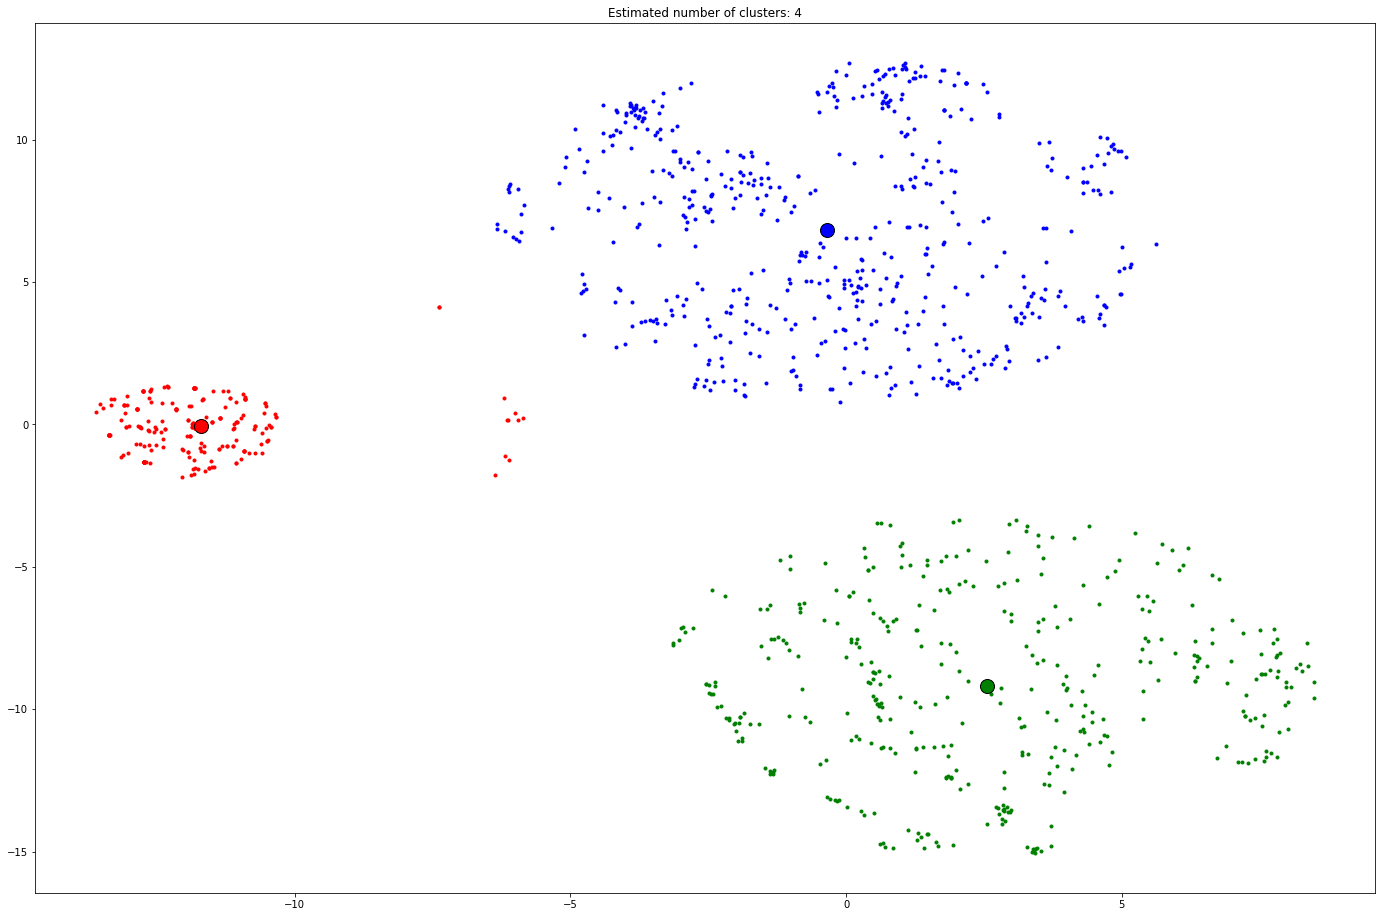

In [71]:
plt.figure()
plt.clf()
X = df.values
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_-1), colors):
    my_members = labels == k
    print(col, cluster_centers[k], k)
    cluster_center = cluster_centers[k]
    plt.plot(X[my_members, 0], X[my_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [ ]:
lbls = np.unique(ms.labels_)

In [ ]:
res['labels']= ms.labels_

In [ ]:
res.to_csv('../csv_files/ModelFiles/photogallery_installedapss_with_cluster_labels_for_ml_model_2.csv')

In [ ]:
def createdf_dict_by_lbl():
    df_dict = {}
    df_anom = {}
    for i in np.nditer(lbls):
        lbl = 'label-' + str(i)
        df_lbl_i = res[res.labels == i]
        del df_lbl_i['labels']
        df_dict[lbl] = df_lbl_i
    return df_dict
    
def create_df_by_func(func):
    for i in np.nditer(lbls):
        if i >= 0:
            df_lbl_i = res[res.labels == i]
            del df_lbl_i['labels']
            col = 'label-' + str(i)
            if(i == 0):
                df_median = df_lbl_i.agg(func).to_frame()
                df_median = df_median.rename(columns = {0: col})
            else:
                df_median[col] = df_lbl_i.agg(func).values
    return df_median

In [ ]:
df_lbl = createdf_dict_by_lbl()

In [ ]:
df_lbl.keys()

In [ ]:
len(df_lbl['label--1'])

In [ ]:
df_median = create_df_by_func('median')
df_mean = create_df_by_func('mean') 

In [ ]:
plt.figure()
df_median.plot.bar(color=['b', 'g', 'r', 'c', 'm', 'y', 'k', 'b'])

In [ ]:
df_mean.plot.bar(color=['b', 'g', 'r', 'c', 'm', 'y', 'k', 'b'])

In [ ]:
#X = df_lbl['label-0'].values
#Y = MinCovDet().fit(X)
#Y.covariance_

In [ ]:
df_lbl.keys()

In [ ]:
c = df_lbl['label-0'].corr()
plt.matshow(c)
plt.show()

In [ ]:
#del df_lbl5['labels']
#dflbl4 = srlbl4.to_frame()
#dflbl4.rename(columns = {0:'lvl-4'})

In [ ]:
excel = df0.to_excel('csv_files/photo_gallery_yellow.xlsx')

In [ ]:
#read the tags from firebase json file for user register non register and create df with tag column
def create_tag_df(f): # 'entries.json'
    tag_data = json.load(codecs.open(f, 'r', 'utf-8-sig'))
    df_tag = pd.DataFrame(tag_data)
    df_tag = df_tag.rename(columns={'app_userid': ''})
    dftag = df_tag.set_index('')
    return dftag

In [ ]:
dftag = create_tag_df('entries.json')

In [ ]:
dfjoin = df.join(dftag)

In [ ]:
len(dfjoin)

In [ ]:
dfjoin['User_Register'] = dfjoin['User_Register'].fillna('false')
len(dfjoin[dfjoin.User_Register == 'false'])

In [ ]:
dfjoin.to_csv('csv_files/taged_aggresive_photogallery.csv')

In [ ]:
dfjoin.head(5)

In [ ]:
#sns.scatterplot('population', 'Area', data=df, hue='continent')
#sns.lmplot('population', 'Area', data=df, hue='continent', fit_reg=False)
plt.figure(figsize=(10,8))
sns.lmplot(
    x='x_col', 
    y='y_col',
    data=dfjoin,
    hue='User_Register',
    fit_reg=False,
    height=8,
)
plt.show()

--> tSNE for 3D

In [ ]:
tsne_3d = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=300, method='exact')

In [ ]:
nz.shape

In [ ]:
tsne_res_3 = tsne_3d.fit_transform(nz)

In [ ]:
df3 = pd.DataFrame(tsne_res_3, columns=['x_col', 'y_col', 'z_col'], index=inxs)

In [ ]:
df3.head(5)

In [ ]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
plt.axis()
ax.scatter(
    xs = df3['x_col'],
    ys = df3['y_col'],
    zs = df3['z_col'],
    cmap='tab2'
)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
ax.set_zlim(-12, 12)
plt.show()

In [ ]:
bw = estimate_bandwidth(df3, quantile=0.2, n_samples=200)

In [ ]:
ms = MeanShift(bandwidth=bw, bin_seeding=True)
ms.fit(df3)

In [ ]:
labels = ms.labels_
cluster_centers = ms.cluster_centers_
labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

In [ ]:
cluster_centers

In [ ]:
fig = plt.figure()
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.view_init(45, 180)
plt.axis()
X = df3.values
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(X[my_members, 0], X[my_members, 1], X[my_members, 2], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], cluster_center[2], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
plt.title('Estimated number of 3D clusters: %d' % n_clusters_)
plt.show()

In [ ]:
dfj3 = df3.join(dftag)
dfj3['User_Register'] = dfj3['User_Register'].fillna('false')
dfj3['User_Register'] = dfj3['User_Register'].map({'true': 'blue', 'false': 'red'})

In [ ]:
len(dfj3[dfj3.User_Register == 'blue'])

In [ ]:
%matplotlib inline
#%matplotlib notebook

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
#ax = plt.figure(figsize=(16,10)).gca(projection='3d')
fig = plt.figure()
ax = Axes3D(plt.figure(figsize=(10,8)))
ax.view_init(45, 180)
plt.axis()
ax.scatter(
    xs = dfj3['x_col'],
    ys = dfj3['y_col'],
    zs = dfj3['z_col'],
    c=dfj3['User_Register'],
    cmap='coolwarm'
)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_xlim(-12, 12)
ax.set_ylim(-12, 12)
ax.set_zlim(-12, 12)
plt.show()

In [ ]:
type(ax)